In [25]:
import sys
import os
sys.path.append('eif')  

In [26]:
from eif import iForest as ExtendedIForest
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
import time
from sklearn.ensemble import IsolationForest
from pyod.models.iforest import IForest
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_openml
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM

In [27]:
def load_dataset(dataset_name):
    expected_anomaly_pct = {
        "arrhythmia": 15.0,
        "pima": 35.0,
        "spambase": 39.4,
        "satellite": 32.0,
        "pendigits": 2.27,
        "mnist": 9.2,
        "forestcover": 0.9
    }

    if dataset_name == "mnist":
        X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
        y = (y == '0').astype(int)
    elif dataset_name == "arrhythmia":
        data = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/arrhythmia/arrhythmia.data', header=None)
        data = data.replace('?', np.nan)
        data = data.astype(float) 
        data = data.fillna(data.mean())
        X = data.iloc[:, :-1].values
        anomaly_classes = [3, 4, 5, 7, 8, 9, 14, 15]
        y = data.iloc[:, -1].isin(anomaly_classes).astype(int)
    elif dataset_name == "pima":
        data = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv', 
                           header=None,
                           names=['pregnancies', 'glucose', 'blood_pressure', 'skin_thickness', 
                                 'insulin', 'bmi', 'diabetes_pedigree', 'age', 'class'])
        X = data.iloc[:, :-1].values 
        y = data.iloc[:, -1].values  
    elif dataset_name == "spambase":
        data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/spambase/spambase.data', header=None)
        X = data.iloc[:, :-1].values
        y = data.iloc[:, -1].values
    elif dataset_name == "satellite":
        data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/satimage/sat.trn', delim_whitespace=True, header=None)
        X = data.iloc[:, :-1].values
        y = (data.iloc[:, -1] == 4).astype(int)  
    elif dataset_name == "pendigits":
        data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/pendigits/pendigits.tra', delimiter=',', header=None)
        X = data.iloc[:, :-1].values
        y = (data.iloc[:, -1] == 4).astype(int) 
    elif dataset_name == "annthyroid":
        data = pd.read_csv('http://odds.cs.stonybrook.edu/wp-content/uploads/2016/12/annthyroid.csv.gz')
        X = data.iloc[:, :-1].values  
        y = data.iloc[:, -1].values  
    elif dataset_name == "forestcover":
        data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/covtype/covtype.data.gz', delimiter=',', header=None)
        X = data.iloc[:, :-1].values
        y = (data.iloc[:, -1] == 4).astype(int) 
    else:
        raise ValueError(f"Dataset {dataset_name} not implemented")
    
    actual_anomaly_pct = (y.sum() / len(y)) * 100
    print(f"\nDataset: {dataset_name}")
    print(f"Expected anomaly percentage: {expected_anomaly_pct[dataset_name]:.2f}%")
    print(f"Actual anomaly percentage: {actual_anomaly_pct:.2f}%")
    print(f"Number of samples: {len(y)}")
    print(f"Number of features: {X.shape[1]}")
    
    return X, y

In [28]:
def evaluate_model(clf, X_train, X_test, y_test):
    start_time = time.time()
    if isinstance(clf, ExtendedIForest):
        # EIF is already fitted during construction
        pass
    else:
        clf.fit(X_train)
    training_time = time.time() - start_time
    
    start_time = time.time()
    if isinstance(clf, ExtendedIForest):
        y_scores = clf.compute_paths(X_test)  
    elif isinstance(clf, IForest):
        y_scores = clf.decision_function(X_test)
    else:
        y_scores = -clf.score_samples(X_test) 
    
    inference_time = time.time() - start_time
    
    auc = roc_auc_score(y_test, y_scores)
    
    return {
        'auc': auc,
        'training_time': training_time,
        'inference_time': inference_time
    }

datasets = ["arrhythmia",
        "pima",
        "spambase",
        "satellite",
        "pendigits",
        "mnist",
        "forestcover"]
models = {
        'iForest-original': lambda: IForest(
        n_estimators=100,
        max_samples=256,
        max_features=1.0,
        bootstrap=False,
        random_state=42
    ),
    
    'iForest-unlimited': lambda: IForest(
        n_estimators=200,
        max_samples='auto',
        max_features=1.0,
        bootstrap=False,
        random_state=42
    ),
    
    'LOF': lambda: LocalOutlierFactor(
        n_neighbors=20,
        contamination='auto',
        novelty=True
    ),
    
    'EIF': lambda X_train: ExtendedIForest(
        X_train,
        ntrees=100,
        sample_size=256,
        limit=1
    )
}

results = []

for dataset_name in datasets:
    X, y = load_dataset(dataset_name)
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    for model_name, model_constructor in models.items():
        print(f"\nTraining {model_name} on {dataset_name}...")
        clf = model_constructor(X_train) if model_name == 'EIF' else model_constructor()
        metrics = evaluate_model(clf, X_train, X_test, y_test)
        results.append({
            'Dataset': dataset_name,
            'Model': model_name,
            **metrics
        })

results_df = pd.DataFrame(results)


Dataset: arrhythmia
Expected anomaly percentage: 15.00%
Actual anomaly percentage: 14.60%
Number of samples: 452
Number of features: 279

Training iForest-original on arrhythmia...

Training iForest-unlimited on arrhythmia...

Training LOF on arrhythmia...

Training EIF on arrhythmia...

Dataset: pima
Expected anomaly percentage: 35.00%
Actual anomaly percentage: 34.90%
Number of samples: 768
Number of features: 8

Training iForest-original on pima...

Training iForest-unlimited on pima...

Training LOF on pima...

Training EIF on pima...

Dataset: spambase
Expected anomaly percentage: 39.40%
Actual anomaly percentage: 39.40%
Number of samples: 4601
Number of features: 57

Training iForest-original on spambase...

Training iForest-unlimited on spambase...

Training LOF on spambase...

Training EIF on spambase...


C:\Users\user\AppData\Local\Temp\ipykernel_30344\3213449140.py:35: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/satimage/sat.trn', delim_whitespace=True, header=None)



Dataset: satellite
Expected anomaly percentage: 32.00%
Actual anomaly percentage: 9.36%
Number of samples: 4435
Number of features: 36

Training iForest-original on satellite...

Training iForest-unlimited on satellite...

Training LOF on satellite...

Training EIF on satellite...

Dataset: pendigits
Expected anomaly percentage: 2.27%
Actual anomaly percentage: 10.41%
Number of samples: 7494
Number of features: 16

Training iForest-original on pendigits...

Training iForest-unlimited on pendigits...

Training LOF on pendigits...

Training EIF on pendigits...


c:\Python310\lib\site-packages\sklearn\datasets\_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(



Dataset: mnist
Expected anomaly percentage: 9.20%
Actual anomaly percentage: 9.86%
Number of samples: 70000
Number of features: 784

Training iForest-original on mnist...

Training iForest-unlimited on mnist...

Training LOF on mnist...

Training EIF on mnist...

Dataset: forestcover
Expected anomaly percentage: 0.90%
Actual anomaly percentage: 0.47%
Number of samples: 581012
Number of features: 54

Training iForest-original on forestcover...

Training iForest-unlimited on forestcover...

Training LOF on forestcover...

Training EIF on forestcover...



Performance Metrics Table:
    Dataset             Model   auc  training_time  inference_time
 arrhythmia  iForest-original 0.815          0.274           0.033
 arrhythmia iForest-unlimited 0.823          0.437           0.068
 arrhythmia               LOF 0.810          0.018           0.009
 arrhythmia               EIF 0.703          0.000           0.005
       pima  iForest-original 0.694          0.194           0.040
       pima iForest-unlimited 0.695          0.402           0.055
       pima               LOF 0.649          0.007           0.003
       pima               EIF 0.727          0.000           0.001
   spambase  iForest-original 0.604          0.380           0.064
   spambase iForest-unlimited 0.602          0.783           0.104
   spambase               LOF 0.477          0.066           0.018
   spambase               EIF 0.631          0.000           0.017
  satellite  iForest-original 0.238          0.398           0.048
  satellite iForest-unlimited 0.21

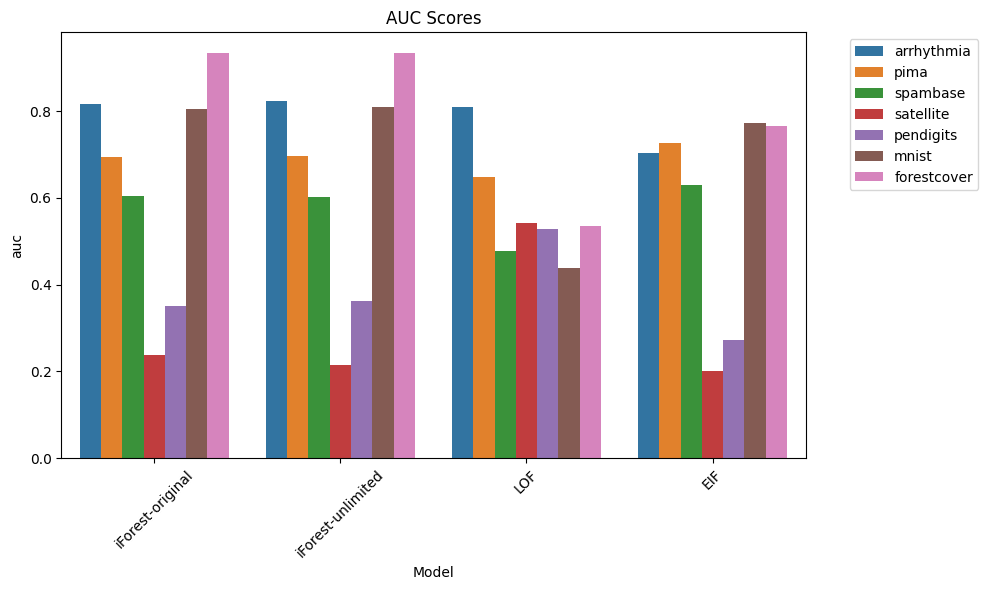

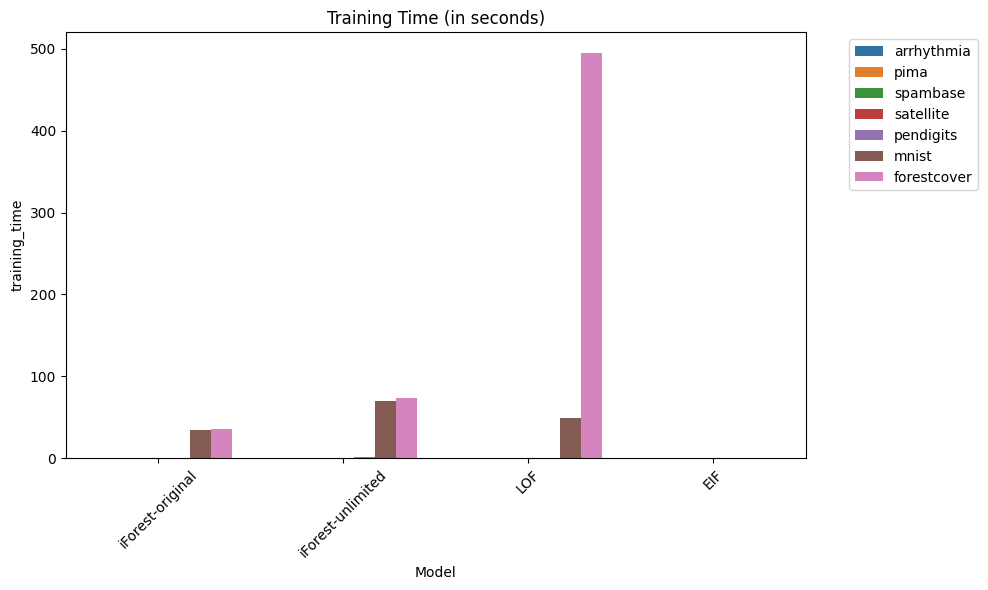

In [32]:
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=results_df, x='Model', y='auc', hue='Dataset')
plt.title('AUC Scores')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('auc_comparison.png', bbox_inches='tight') 

plt.figure(figsize=(10, 6))
ax = sns.barplot(data=results_df, x='Model', y='training_time', hue='Dataset')
plt.title('Training Time (in seconds)')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('training_time_comparison.png', bbox_inches='tight')

print("\nPerformance Metrics Table:")
print(results_df.round(3).to_string(index=False))